Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

from sklearn.neighbors import NearestNeighbors
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# Global utitlity functions are in separate notebook
%run ./utility-functions.ipynb
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- B

In [21]:
import sklearn
sklearn.__dir__()
sklearn.__version__

'1.0.2'

In [22]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "EMA_x_a",
        "EMA_y_a",
        "EMA_z_a",
        "EMA_x_g",
        "EMA_y_g",
        "EMA_z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    ocsvm_nu=0.037,
    ocsvm_gamma= 0.001,
)
# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [23]:
P = VALID_ROBUST_OCSVM
# P = VALID_NORMALIZER_OCSVM

In [24]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [25]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [26]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [27]:
len(dfList_exp1)

29

In [28]:


# Number of sample points
# for i in range(len(dfList_exp2)):
i =1
N = np.array(dfList_exp2[i]['EMA_x_a']).shape[0]
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.array(np.sqrt(dfList_exp2[i]['EMA_x_a']**2 + dfList_exp2[i]['EMA_y_a']**2 + dfList_exp2[i]['EMA_z_a']**2))
y = np.array(dfList_exp2[i]['EMA_x_a'])

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

KeyError: 'EMA_x_a'

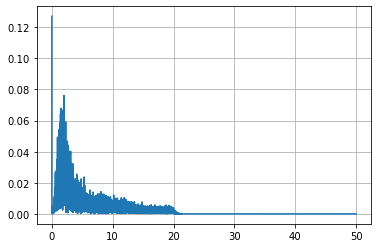

In [11]:

i=1
N = np.array(dfList_exp2[i]['EMA_x_a']).shape[0]
# sample spacing
T = 1.0 / 100

sos = signal.butter(50, 20, 'lowpass', fs=100, output='sos')
sig = np.array(dfList_exp2[i]['EMA_x_a'])
y = signal.sosfilt(sos, sig) #filtered time domain signal


yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

# dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']
# N = np.array(dfList_exp2[i]['EMA_x_g']).shape[0]
# # sample spacing
# T = 1.0 / 100

# t = np.linspace(0.0, N*T, N, endpoint=False)

# plt.plot(t, filtered)
# # plt.set_title('After 10 Hz high-pass filter')
# plt.axis([0, 1, -2, 2])
# # plt.set_xlabel('Time [seconds]')
# plt.tight_layout

In [13]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

<AxesSubplot:>

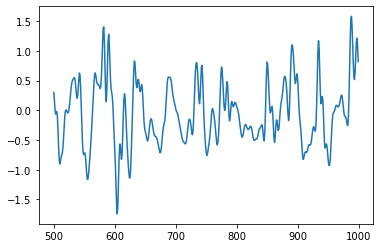

In [15]:
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=17
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[i]['EMA_x_a'][500:1000].plot()
# dfList_exp1 = EMAed_dfList_exp1
# dfList_exp2 = EMAed_dfList_exp2

<AxesSubplot:>

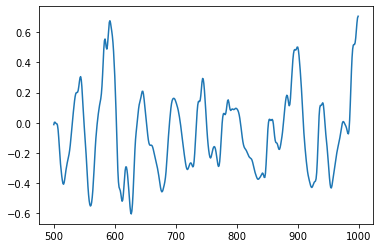

In [16]:
P.span=23
P.smoothing = "FFT+EMA"
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[i]['EMA_x_a'][500:1000].plot()

In [17]:
dfList_exp1 = EMAed_dfList_exp1
dfList_exp2 = EMAed_dfList_exp2

In [18]:
# y=apply_butter(dfList_exp2[i]['EMA_x_a'])

In [19]:
# raw_dfList_exp2[i]['EMA_x_a'].ewm(span=5,adjust=False).mean()[500:1000].plot()

In [20]:
# plt.plot(range(y[500:1000].shape[0]), y[500:1000])
# plt.grid()
# plt.show()

In [21]:
# raw_dfList_exp2[i]['EMA_x_a'][500:1000].plot()

In [22]:
# dfList_exp2[i]['EMA_x_a'][500:1000].plot()

In [23]:
# dfList_exp2[i]['EMA_x_a'].ewm(span=5,adjust=False).mean()[500:1000].plot()

In [24]:
# i=0
# dfList_exp1[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_g']].plot(figsize=(30, 6))

# dfList_exp2[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_g']].plot(figsize=(30, 6))
# exp1 idx 10 has corrupted data frist 50 sec
# exp2 idx 12 has some artifacts first 12.5 sec
# exp1 idx 17 has some artifacts first 75 sec
# exp2 idx 23 has some artifacts last 6.5 sec

In [29]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
train_set = randomized_data_idx
print(f"train_set: {train_set}\ntest_set: {test_set}")
train_set = test_set
# test_set = train_set
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
train_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [30]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

train_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [31]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [53]:
n_neighbors_params=[10]
window_size=1000
overlap=.5
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None
P.Butter_per_win_argdict=None
P.scaler_clip=False
P.p=2
P.scaler="RobustScaler"

EER_distro_df_dict = {}
columns = ['window_size', "step_width", "Mean_EER", "best_n_neighbors"]
Mean_EER_df = pd.DataFrame(columns = columns)

for window_size in WINDOW_SIZE_LST:
    print(f"window_size: {window_size}")

    step_width = int(window_size * (1-overlap))

    X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, 
                                                                                        P.num_sample_points_per_exp, 
                                                                                        EMA_per_win_span=P.EMA_per_win_span, 
                                                                                        SMA_per_win_winsize=P.SMA_per_win_winsize,
                                                                                        Butter_per_win_argdict=P.Butter_per_win_argdict, 
                                                                                        verbose=0)

    X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, scaler_clip=P.scaler_clip)


    mean_eer_dict = {}
    for n_neighbors in n_neighbors_params:
        EER_distro_df = make_EER_distro_df(X_exp_train_dic, n_neighbors=n_neighbors, algorithm='brute', exp_config=P, verbose=0)
        EER_distro_df_dict[f"window_size: {window_size}, step_width: {step_width}"] = EER_distro_df

        y_col = "EER"
        mean_col = EER_distro_df[y_col].mean()
        # print(EER_distro_df)
        mean_eer_dict[n_neighbors] = mean_col

    # print(mean_eer_dict)
    best_n_neighbors = min(mean_eer_dict, key=mean_eer_dict.get)
    Mean_EER = mean_eer_dict[best_n_neighbors]

    new_row = pd.DataFrame([[window_size, step_width, Mean_EER, best_n_neighbors]], columns=columns)
    Mean_EER_df = pd.concat([Mean_EER_df, new_row])

window_size: 125
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  6.269307350739837
MakeWACAXExpDicUnknown Time:  32.709464482963085
Done extracting features
window_size: 250
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  3.1676120664924383
MakeWACAXExpDicUnknown Time:  16.634338923729956
Done extracting features
window_size: 500
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  1.5844371654093266
MakeWACAXExpDicUnknown Time:  8.711829050444067
Done extracting features
window_size: 750
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  1.1190148759633303
MakeWACAXExpDicUnknown Time:  6.168321079574525
Done extracting features
window_size: 1000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  1.089555747807026
MakeWACAXExpDicUnknown Time:  4.83859378285706
Done extracting features
windo

In [45]:
Mean_EER_df

,window_size,step_width,Mean_EER,best_n_neighbors
0,125,62,0.241675,10
0,250,125,0.150699,10
0,500,250,0.10241,10
0,750,375,0.092929,10
0,1000,500,0.087127,10
0,1250,625,0.078472,10
0,1500,750,0.07428,10
0,1750,875,0.078502,10
0,2000,1000,0.083333,10


In [48]:
Mean_EER_df

,window_size,step_width,Mean_EER,best_n_neighbors
0,125,62,0.281042,10
0,250,125,0.173752,10
0,500,250,0.1251,10
0,750,375,0.10101,10
0,1000,500,0.090379,10
0,1250,625,0.07934,10
0,1500,750,0.077572,10
0,1750,875,0.075845,10
0,2000,1000,0.075833,10


In [50]:
Mean_EER_df

,window_size,step_width,Mean_EER,best_n_neighbors
0,125,62,0.28091,10
0,250,125,0.17495,10
0,500,250,0.124029,10
0,750,375,0.104141,10
0,1000,500,0.090921,10
0,1250,625,0.084375,10
0,1500,750,0.080247,10
0,1750,875,0.078261,10
0,2000,1000,0.077778,10


In [52]:
Mean_EER_df

,window_size,step_width,Mean_EER,best_n_neighbors
0,125,62,0.24151,10
0,250,125,0.150665,10
0,500,250,0.103079,10
0,750,375,0.092525,10
0,1000,500,0.086585,10
0,1250,625,0.078472,10
0,1500,750,0.077366,10
0,1750,875,0.078019,10
0,2000,1000,0.083889,10


In [54]:
Mean_EER_df

,window_size,step_width,Mean_EER,best_n_neighbors
0,125,62,0.241675,10
0,250,125,0.150699,10
0,500,250,0.10241,10
0,750,375,0.092929,10
0,1000,500,0.087127,10
0,1250,625,0.078472,10
0,1500,750,0.07428,10
0,1750,875,0.078502,10
0,2000,1000,0.083333,10


In [32]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()
dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47
# EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
# EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
# EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
# dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows_3(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.ocsvm_step_width, 
                                                                                                  scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                  EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                               X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows_3(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


AttributeError: 'ExperimentParameters' object has no attribute 'cut_off_freq'

In [30]:
# OCSVM_test_train_WACA_features_dic[0].shape

In [31]:
# def normalize_extracted_features(OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic, OCSVM_test_train_WACA_features_dic, OCSVM_test_test_WACA_features_dic, scaler_clip=True):
#     train_train_WACA_features_result = scale_feature_windows(OCSVM_train_train_WACA_features_dic, fitted_scaler_dic=None, scaler_type="MinMaxScaler", scaler_clip=scaler_clip)
#     OCSVM_train_train_WACA_features_dic, fitted_scaler_dic = train_train_WACA_features_result["X_exp_dic"], train_train_WACA_features_result["fitted_scaler_dic"]

#     train_valid_WACA_features_result = scale_feature_windows(OCSVM_train_valid_WACA_features_dic, fitted_scaler_dic=fitted_scaler_dic)
#     OCSVM_train_valid_WACA_features_dic = train_valid_WACA_features_result["X_exp_dic"]

#     return OCSVM_train_train_WACA_features_dic, fitted_scaler_dic, OCSVM_train_valid_WACA_features_dic

In [32]:
def plot_EER_distro(EER_distro_df, discription, save_file_name=None):
    y_col = "EER"
    figsize=(30, 6)
    fontsize=11
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()

    fig = plt.figure(figsize=figsize, dpi=180)
    ax = sns.boxplot(x="gen_user_id", y=y_col, data=EER_distro_df)#, **utils_boxplot_style)
    ax.set_ylim((0, 1))
    sns.swarmplot(x="gen_user_id", y=y_col, data=EER_distro_df, color=".25")

    plt.plot(
        [-0.6, figsize[0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=fontsize, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=fontsize, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
    plt.savefig(f'{save_file_name}.png', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")

In [34]:
print(1)

1


In [37]:
# window_size, step_width = 500, 500
# X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic = \
#     get_raw_windows(window_size, step_width)
# X_exp_train_dic, X_exp_test_dic = \
#     extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

# EER_distro_df = make_EER_distro_df(OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic)
# EER_distro_df

NameError: name 'plot_EER_distro' is not defined

In [39]:
'''
EER_distro_df = make_EER_distro_df(X_exp_train_dic)
EER_distro_df

columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
Mean_EER_df = pd.DataFrame(columns = columns)
y_col = "EER"
mean_col = EER_distro_df[y_col].mean()
Mean_EER = mean_col

new_row = pd.DataFrame([[window_size, step_width, True, Mean_EER]], columns=columns)
Mean_EER_df = pd.concat([Mean_EER_df, new_row])
'''

'\nEER_distro_df = make_EER_distro_df(X_exp_train_dic)\nEER_distro_df\n\ncolumns = [\'window_size\', "step_width", "scaler_clip", "Mean_EER"]\nMean_EER_df = pd.DataFrame(columns = columns)\ny_col = "EER"\nmean_col = EER_distro_df[y_col].mean()\nMean_EER = mean_col\n\nnew_row = pd.DataFrame([[window_size, step_width, True, Mean_EER]], columns=columns)\nMean_EER_df = pd.concat([Mean_EER_df, new_row])\n'

In [40]:
#X_exp_train_dic[0]["profile_windows"].max(axis=0)

In [41]:
# overlap

In [42]:
def calculate_EER_different_window_sizes(overlap=.25):
    EER_distro_df_dict = {}
    window_size_lst = [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]# 
    scaler_clip = True
    columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
    Mean_EER_df = pd.DataFrame(columns = columns)
    for window_size in tqdm(window_size_lst):
        print(window_size)
        # blockPrint()
        step_width = int(window_size * (1-overlap))
        X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic = \
            get_raw_windows(window_size, step_width)
        X_exp_train_dic, X_exp_test_dic = \
            extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

        EER_distro_df = make_EER_distro_df(X_exp_train_dic)
        EER_distro_df_dict[f"window_size: {window_size}, step_width: {step_width}, scaler_clip: {scaler_clip}"] = EER_distro_df

        y_col = "EER"
        mean_col = EER_distro_df[y_col].mean()
        Mean_EER = mean_col

        new_row = pd.DataFrame([[window_size, step_width, scaler_clip, Mean_EER]], columns=columns)
        Mean_EER_df = pd.concat([Mean_EER_df, new_row])
        # enablePrint()
    return Mean_EER_df

In [43]:
overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
for overlap in overlap_Mean_EER_df_dict:
    overlap_Mean_EER_df_dict[overlap] = calculate_EER_different_window_sizes(overlap)

  0%|          | 0/9 [00:00<?, ?it/s]

125
len(dfList_exp1_train): 10
len(dfList_exp2_train): 10
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(26943, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(25829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: RobustScaler
(24314, 6)
user_idx: 3, exp_num: 2, scale: True, scaler: RobustScaler
(24444, 6)
user_idx: 4, exp_num: 2, scale: True, scaler: RobustScaler
(21182, 6)
user_idx: 5, exp_num: 2, scale: True, scaler: RobustScaler
(23982, 6)
user_idx: 6, exp_num: 2, scale: True, scaler: RobustScaler
(27000, 6)
user_idx: 7, exp_num: 2, scale: True, scaler: RobustScaler
(23854, 6)
user_idx: 8, exp_num: 2, scale: True, scaler: RobustScaler
(24589, 6)
user_idx: 9, exp_num: 2, scale: True, scaler: RobustScaler
(23573, 6)
len(dfList_exp1_test): 10
len(dfList_exp2_test): 10
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(26943, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(25829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: Robu

 11%|█         | 1/9 [08:56<1:11:34, 536.87s/it]

EER: 0.311572700, owner_id: 9, adv_user_id: 6, Threshold: 0.724460251
EER: 0.483679525, owner_id: 9, adv_user_id: 7, Threshold: 0.837921236
EER: 0.175074184, owner_id: 9, adv_user_id: 8, Threshold: 0.750920600
250
len(dfList_exp1_train): 10
len(dfList_exp2_train): 10
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(26943, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(25829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: RobustScaler
(24314, 6)
user_idx: 3, exp_num: 2, scale: True, scaler: RobustScaler
(24444, 6)
user_idx: 4, exp_num: 2, scale: True, scaler: RobustScaler
(21182, 6)
user_idx: 5, exp_num: 2, scale: True, scaler: RobustScaler
(23982, 6)
user_idx: 6, exp_num: 2, scale: True, scaler: RobustScaler
(27000, 6)
user_idx: 7, exp_num: 2, scale: True, scaler: RobustScaler
(23854, 6)
user_idx: 8, exp_num: 2, scale: True, scaler: RobustScaler
(24589, 6)
user_idx: 9, exp_num: 2, scale: True, scaler: RobustScaler
(23573, 6)
len(dfList_exp1_test): 10
len(df

 22%|██▏       | 2/9 [13:28<44:26, 380.91s/it]  

EER: 0.089820359, owner_id: 7, adv_user_id: 8, Threshold: 0.724625264
EER: 0.281437126, owner_id: 7, adv_user_id: 9, Threshold: 0.787829522
EER: 0.191616766, owner_id: 8, adv_user_id: 0, Threshold: 0.789672908
EER: 0.203592814, owner_id: 8, adv_user_id: 1, Threshold: 0.795906547
EER: 0.203592814, owner_id: 8, adv_user_id: 2, Threshold: 0.798899132
EER: 0.311377246, owner_id: 8, adv_user_id: 3, Threshold: 0.854577215
EER: 0.245508982, owner_id: 8, adv_user_id: 4, Threshold: 0.824146996
EER: 0.203592814, owner_id: 8, adv_user_id: 5, Threshold: 0.791824785
EER: 0.185628743, owner_id: 8, adv_user_id: 6, Threshold: 0.781456088
EER: 0.191616766, owner_id: 8, adv_user_id: 7, Threshold: 0.791052565
EER: 0.221556886, owner_id: 8, adv_user_id: 9, Threshold: 0.811874815
EER: 0.293413174, owner_id: 9, adv_user_id: 0, Threshold: 0.706035120
EER: 0.323353293, owner_id: 9, adv_user_id: 1, Threshold: 0.720976815
EER: 0.185628743, owner_id: 9, adv_user_id: 2, Threshold: 0.654677729
EER: 0.095808383, ow

 33%|███▎      | 3/9 [15:47<27:03, 270.63s/it]

EER: 0.024096386, owner_id: 6, adv_user_id: 3, Threshold: 0.402091441
EER: 0.048192771, owner_id: 6, adv_user_id: 4, Threshold: 0.435320836
EER: 0.036144578, owner_id: 6, adv_user_id: 5, Threshold: 0.379241654
EER: 0.096385542, owner_id: 6, adv_user_id: 7, Threshold: 0.610646600
EER: 0.072289157, owner_id: 6, adv_user_id: 8, Threshold: 0.653858926
EER: 0.084337349, owner_id: 6, adv_user_id: 9, Threshold: 0.520692246
EER: 0.108433735, owner_id: 7, adv_user_id: 0, Threshold: 0.645958707
EER: 0.240963855, owner_id: 7, adv_user_id: 1, Threshold: 0.723975601
EER: 0.096385542, owner_id: 7, adv_user_id: 2, Threshold: 0.576529401
EER: 0.072289157, owner_id: 7, adv_user_id: 3, Threshold: 0.540633784
EER: 0.096385542, owner_id: 7, adv_user_id: 4, Threshold: 0.581414439
EER: 0.108433735, owner_id: 7, adv_user_id: 5, Threshold: 0.638187786
EER: 0.108433735, owner_id: 7, adv_user_id: 6, Threshold: 0.642087062
EER: 0.096385542, owner_id: 7, adv_user_id: 8, Threshold: 0.675267000
EER: 0.228915663, ow

 44%|████▍     | 4/9 [17:23<16:47, 201.48s/it]

EER: 0.109090909, owner_id: 7, adv_user_id: 4, Threshold: 0.540644201
EER: 0.163636364, owner_id: 7, adv_user_id: 5, Threshold: 0.659710224
EER: 0.109090909, owner_id: 7, adv_user_id: 6, Threshold: 0.554076515
EER: 0.109090909, owner_id: 7, adv_user_id: 8, Threshold: 0.665082656
EER: 0.218181818, owner_id: 7, adv_user_id: 9, Threshold: 0.742462318
EER: 0.254545455, owner_id: 8, adv_user_id: 0, Threshold: 0.730710809
EER: 0.254545455, owner_id: 8, adv_user_id: 1, Threshold: 0.715935197
EER: 0.254545455, owner_id: 8, adv_user_id: 2, Threshold: 0.718427986
EER: 0.254545455, owner_id: 8, adv_user_id: 3, Threshold: 0.752122127
EER: 0.254545455, owner_id: 8, adv_user_id: 4, Threshold: 0.757380389
EER: 0.254545455, owner_id: 8, adv_user_id: 5, Threshold: 0.707257102
EER: 0.254545455, owner_id: 8, adv_user_id: 6, Threshold: 0.713666801
EER: 0.254545455, owner_id: 8, adv_user_id: 7, Threshold: 0.749402508
EER: 0.254545455, owner_id: 8, adv_user_id: 9, Threshold: 0.747853514
EER: 0.218181818, ow

 56%|█████▌    | 5/9 [18:36<10:21, 155.28s/it]

EER: 0.268292683, owner_id: 7, adv_user_id: 9, Threshold: 0.650433495
EER: 0.268292683, owner_id: 8, adv_user_id: 0, Threshold: 0.688773972
EER: 0.268292683, owner_id: 8, adv_user_id: 1, Threshold: 0.710945420
EER: 0.268292683, owner_id: 8, adv_user_id: 2, Threshold: 0.686791453
EER: 0.243902439, owner_id: 8, adv_user_id: 3, Threshold: 0.674171318
EER: 0.268292683, owner_id: 8, adv_user_id: 4, Threshold: 0.720466341
EER: 0.268292683, owner_id: 8, adv_user_id: 5, Threshold: 0.724934313
EER: 0.268292683, owner_id: 8, adv_user_id: 6, Threshold: 0.710772281
EER: 0.317073171, owner_id: 8, adv_user_id: 7, Threshold: 0.777432213
EER: 0.268292683, owner_id: 8, adv_user_id: 9, Threshold: 0.720297903
EER: 0.268292683, owner_id: 9, adv_user_id: 0, Threshold: 0.411755198
EER: 0.219512195, owner_id: 9, adv_user_id: 1, Threshold: 0.381610932
EER: 0.317073171, owner_id: 9, adv_user_id: 2, Threshold: 0.523025825
EER: 0.121951220, owner_id: 9, adv_user_id: 3, Threshold: 0.401683461
EER: 0.195121951, ow

 67%|██████▋   | 6/9 [19:35<06:07, 122.53s/it]

EER: 0.312500000, owner_id: 8, adv_user_id: 0, Threshold: 0.732783244
EER: 0.281250000, owner_id: 8, adv_user_id: 1, Threshold: 0.673006235
EER: 0.281250000, owner_id: 8, adv_user_id: 2, Threshold: 0.677509170
EER: 0.281250000, owner_id: 8, adv_user_id: 3, Threshold: 0.678094058
EER: 0.312500000, owner_id: 8, adv_user_id: 4, Threshold: 0.736623296
EER: 0.312500000, owner_id: 8, adv_user_id: 5, Threshold: 0.708100634
EER: 0.312500000, owner_id: 8, adv_user_id: 6, Threshold: 0.727886494
EER: 0.375000000, owner_id: 8, adv_user_id: 7, Threshold: 0.799418291
EER: 0.343750000, owner_id: 8, adv_user_id: 9, Threshold: 0.778453267
EER: 0.218750000, owner_id: 9, adv_user_id: 0, Threshold: 0.430086920
EER: 0.218750000, owner_id: 9, adv_user_id: 1, Threshold: 0.436480010
EER: 0.281250000, owner_id: 9, adv_user_id: 2, Threshold: 0.519663191
EER: 0.156250000, owner_id: 9, adv_user_id: 3, Threshold: 0.408000493
EER: 0.218750000, owner_id: 9, adv_user_id: 4, Threshold: 0.424627069
EER: 0.187500000, ow

 78%|███████▊  | 7/9 [20:27<03:18, 99.24s/it] 

EER: 0.259259259, owner_id: 8, adv_user_id: 0, Threshold: 0.639411902
EER: 0.259259259, owner_id: 8, adv_user_id: 1, Threshold: 0.609174114
EER: 0.296296296, owner_id: 8, adv_user_id: 2, Threshold: 0.667223478
EER: 0.259259259, owner_id: 8, adv_user_id: 3, Threshold: 0.647771912
EER: 0.259259259, owner_id: 8, adv_user_id: 4, Threshold: 0.655750504
EER: 0.296296296, owner_id: 8, adv_user_id: 5, Threshold: 0.700386996
EER: 0.296296296, owner_id: 8, adv_user_id: 6, Threshold: 0.681947559
EER: 0.333333333, owner_id: 8, adv_user_id: 7, Threshold: 0.756877701
EER: 0.296296296, owner_id: 8, adv_user_id: 9, Threshold: 0.700738458
EER: 0.296296296, owner_id: 9, adv_user_id: 0, Threshold: 0.565567423
EER: 0.185185185, owner_id: 9, adv_user_id: 1, Threshold: 0.483423949
EER: 0.259259259, owner_id: 9, adv_user_id: 2, Threshold: 0.565297945
EER: 0.074074074, owner_id: 9, adv_user_id: 3, Threshold: 0.475958937
EER: 0.148148148, owner_id: 9, adv_user_id: 4, Threshold: 0.445079930
EER: 0.111111111, ow

 89%|████████▉ | 8/9 [21:12<01:21, 81.99s/it]

EER: 0.260869565, owner_id: 8, adv_user_id: 2, Threshold: 0.706580547
EER: 0.260869565, owner_id: 8, adv_user_id: 3, Threshold: 0.713957962
EER: 0.260869565, owner_id: 8, adv_user_id: 4, Threshold: 0.712806765
EER: 0.260869565, owner_id: 8, adv_user_id: 5, Threshold: 0.691619966
EER: 0.260869565, owner_id: 8, adv_user_id: 6, Threshold: 0.673009549
EER: 0.347826087, owner_id: 8, adv_user_id: 7, Threshold: 0.783504629
EER: 0.260869565, owner_id: 8, adv_user_id: 9, Threshold: 0.683397383
EER: 0.391304348, owner_id: 9, adv_user_id: 0, Threshold: 0.597907187
EER: 0.130434783, owner_id: 9, adv_user_id: 1, Threshold: 0.458962821
EER: 0.217391304, owner_id: 9, adv_user_id: 2, Threshold: 0.501253005
EER: 0.130434783, owner_id: 9, adv_user_id: 3, Threshold: 0.585675184
EER: 0.086956522, owner_id: 9, adv_user_id: 4, Threshold: 0.389215296
EER: 0.043478261, owner_id: 9, adv_user_id: 5, Threshold: 0.408524361
EER: 0.130434783, owner_id: 9, adv_user_id: 6, Threshold: 0.444165268
EER: 0.347826087, ow

100%|██████████| 9/9 [21:52<00:00, 145.80s/it]

EER: 0.300000000, owner_id: 8, adv_user_id: 4, Threshold: 0.677911143
EER: 0.300000000, owner_id: 8, adv_user_id: 5, Threshold: 0.704805331
EER: 0.300000000, owner_id: 8, adv_user_id: 6, Threshold: 0.674175602
EER: 0.350000000, owner_id: 8, adv_user_id: 7, Threshold: 0.798243129
EER: 0.300000000, owner_id: 8, adv_user_id: 9, Threshold: 0.631899513
EER: 0.300000000, owner_id: 9, adv_user_id: 0, Threshold: 0.515271720
EER: 0.250000000, owner_id: 9, adv_user_id: 1, Threshold: 0.575321789
EER: 0.350000000, owner_id: 9, adv_user_id: 2, Threshold: 0.593562897
EER: 0.150000000, owner_id: 9, adv_user_id: 3, Threshold: 0.479136212
EER: 0.150000000, owner_id: 9, adv_user_id: 4, Threshold: 0.461916303
EER: 0.100000000, owner_id: 9, adv_user_id: 5, Threshold: 0.383240777
EER: 0.100000000, owner_id: 9, adv_user_id: 6, Threshold: 0.395157091
EER: 0.350000000, owner_id: 9, adv_user_id: 7, Threshold: 0.539605129
EER: 0.100000000, owner_id: 9, adv_user_id: 8, Threshold: 0.546316603


In [44]:
# X_exp1_train_dic.keys()

In [45]:
overlap_Mean_EER_df_dict

{0.5:   window_size step_width scaler_clip  Mean_EER
 0         125         62        True  0.213683
 0         250        125        True  0.161144
 0         500        250        True  0.138153
 0         750        375        True  0.137374
 0        1000        500        True  0.141192
 0        1250        625        True  0.135069
 0        1500        750        True  0.153909
 0        1750        875        True  0.142512
 0        2000       1000        True  0.152222}

In [47]:
overlap_Mean_EER_df_dict[0.5]

,window_size,step_width,scaler_clip,Mean_EER
0,125,62,True,0.213683
0,250,125,True,0.161144
0,500,250,True,0.138153
0,750,375,True,0.137374
0,1000,500,True,0.141192
0,1250,625,True,0.135069
0,1500,750,True,0.153909
0,1750,875,True,0.142512
0,2000,1000,True,0.152222


In [ ]:
f = open("overlap_Mean_EER_df_dict_95.txt", "a")
f.write(overlap_Mean_EER_df_dict[0.99].to_string())
f.close()

In [ ]:
Mean_EER_df

In [ ]:
import seaborn as sns; sns.set()

def plot_EER_vs_Windows_Size_graph_per_user():
    y_col = "EER"
    figsize=(30, 6)
    fontsize=11
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()

    fig = plt.figure(figsize=figsize, dpi=180)
    ax = sns.boxplot(x="gen_user_id", y=y_col, data=EER_distro_df)#, **utils_boxplot_style)
    ax.set_ylim((0, 1))
    sns.swarmplot(x="gen_user_id", y=y_col, data=EER_distro_df, color=".25")

    plt.plot(
        [-0.6, figsize[0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=fontsize, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=fontsize, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
#     plt.savefig(f'{save_file_name}.png', bbox_inches='tight')
    
    fmri = sns.load_dataset("fmri")
    fmri_stats = fmri.groupby(['timepoint']).describe()

    x = fmri_stats.index
    medians = fmri_stats[('signal', '50%')]
    medians.name = 'signal'
    quartiles1 = fmri_stats[('signal', '25%')]
    quartiles3 = fmri_stats[('signal', '75%')]

    ax = sns.lineplot(x, medians) 
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3); 

In [ ]:
EER_distro_df_dict[k]

In [ ]:
eer_vs_window_size_per_user_dict = {}
for owner in X_exp_train_dic.keys():
    eer_vs_window_size_per_user_dict[owner] = {}
    
for k in EER_distro_df_dict.keys():
    
    eer_vs_window_df = EER_distro_df_dict[k].groupby("owner").describe()
    for owner in X_exp_train_dic.keys():
        eer_vs_window_size_per_user_dict[owner][k.split()[1].strip(',')] = eer_vs_window_df.iloc[owner]

In [ ]:
# fmri = sns.load_dataset("fmri")
# fmri_stats = fmri.groupby(['timepoint']).describe()

x = list(eer_vs_window_size_per_user_dict[owner].keys())
medians = fmri_stats[('signal', '50%')]
medians.name = 'signal'
quartiles1 = fmri_stats[('signal', '25%')]
quartiles3 = fmri_stats[('signal', '75%')]

ax = sns.lineplot(x, medians) 
ax.fill_between(x, quartiles1, quartiles3, alpha=0.3); 

In [ ]:
eer_vs_window_size_per_user_dict[0].keys()
eer_vs_window_size_per_user_dict[0]["125"]
mean_owner_dic = {}
for owner in eer_vs_window_size_per_user_dict:
    mean_owner_dic[owner] = {}
    mean_owner_dic[owner]["mean"] = {}
    for window_size in eer_vs_window_size_per_user_dict[owner]:
        mean_owner_dic[owner]["mean"][window_size] = (eer_vs_window_size_per_user_dict[owner][window_size].EER.loc['mean'])


# def extract_stats_eer_vs_window_size_per_user_dict(eer_vs_window_size_per_user_dict:
#     eer_vs_window_size_per_user_dict[0].keys()

In [ ]:
figsize=(30, 6)
fontsize=11
fig = plt.figure(figsize=figsize, dpi=180)
for owner in mean_owner_dic:
    ax = sns.lineplot(list(mean_owner_dic[owner]['mean'].keys()), list(mean_owner_dic[owner]['mean'].values()), label=owner, linestyle="-")


In [ ]:
mean_owner_dic[0]['mean'].values()

In [285]:
eer_vs_window_size_per_user_dict[0]

{'125': EER  count    9.000000
      mean     0.239872
      std      0.111323
      min      0.119048
      25%      0.178571
      50%      0.214286
      75%      0.261905
      max      0.501701
 Name: 0, dtype: float64}

In [214]:
# eer_vs_window_df=EER_distro_df_dict[k].groupby("gen_user_id").describe()
# eer_vs_window_df["x"] = k
# for k in list(EER_distro_df_dict.keys())[1:]:
#     new_row = EER_distro_df_dict[k].groupby("gen_user_id").describe()
#     new_row["x"] = k
#     eer_vs_window_df = pd.concat([eer_vs_window_df, new_row])


In [250]:
1

1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [163]:
temp_df_result = EER_distro_df_dict["window_size: 125, step_width: 250, scaler_clip: True"]
temp_df_result[temp_df_result.gen_user_id==0]["EER"].mean()

0.23987150415729216

In [154]:
EER_distro_df_dict["window_size: 125, step_width: 250, scaler_clip: True"].head(10)

,gen_user_id,adv_user_id,EER
0,0,1,0.192857
0,0,2,0.273810
0,0,3,0.178571
0,0,4,0.119048
0,0,5,0.154762
0,0,6,0.501701
0,0,7,0.214286
0,0,8,0.261905
0,0,9,0.261905
0,1,0,0.360119


In [142]:
EER_distro_df_dict.keys()

dict_keys(['window_size: 125, step_width: 250, scaler_clip: True', 'window_size: 250, step_width: 250, scaler_clip: True', 'window_size: 500, step_width: 250, scaler_clip: True', 'window_size: 750, step_width: 250, scaler_clip: True', 'window_size: 1000, step_width: 250, scaler_clip: True', 'window_size: 1250, step_width: 250, scaler_clip: True', 'window_size: 1500, step_width: 250, scaler_clip: True', 'window_size: 1750, step_width: 250, scaler_clip: True', 'window_size: 2000, step_width: 250, scaler_clip: True'])

In [114]:
print(Mean_EER_df["Mean_EER"])

0    0.311363
0    0.235292
0    0.167712
0    0.156379
0    0.163357
0    0.167944
0    0.169635
0    0.171837
0    0.185374
Name: Mean_EER, dtype: float64


In [134]:
for k in EER_distro_df_dict.keys():
    print(k)
#     plot_EER_distro(EER_distro_df_dict[k], k, save_file_name=f'WACA-NN1-{ "".join("-".join(k.split(", ")).split())}')

window_size: 125, step_width: 250, scaler_clip: True
window_size: 250, step_width: 250, scaler_clip: True
window_size: 500, step_width: 250, scaler_clip: True
window_size: 750, step_width: 250, scaler_clip: True
window_size: 1000, step_width: 250, scaler_clip: True
window_size: 1250, step_width: 250, scaler_clip: True
window_size: 1500, step_width: 250, scaler_clip: True
window_size: 1750, step_width: 250, scaler_clip: True
window_size: 2000, step_width: 250, scaler_clip: True


In [132]:
 "".join("-".join(k.split(", ")).split())

'window_size:2000-step_width:250-scaler_clip:True'

In [ ]:
y_col = "EER"
mean_col = EER_distro_df[y_col].mean()
mean_col

In [ ]:
print(len(X_exp2_train_dic[0]))